<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
    <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
<font color='green'><br>
<br />
Ксения, доброго дня! рад приветствовать тебя в финале) <br />
Вот и он подобрался, поздравляю. Остался последний рывок в этом марафоне)<br>
<br />
Меня зовут Николай. <br />И на этом этапе Вашего движения к новой профессии от меня будут комментарии по написанному коду. <br />Чтобы меньше "мусорить эфир" и чтобы максимально наглядно отделяться от основного кода, есть предложение условиться в некоторых обозначениях:<br /> <br />
<u><b>ТАКОЙ ШРИФТ</b></u> - всегда начало комментария <br />
<font color='green'>такой шрифт</font> - комментарии о том, что всё ОК <br/>
<font color='purple'>такой шрифт</font> - комментарии о том, что всё ОК по результату,<br> однако что есть ещё что-то или в коде или есть способы сделать более короткий или быстрый код <br/>
<font color='red'>такой шрифт</font> - комментарии о том, что есть критичный момент, влияющий на бизнес-результат проекта.<br/>
</font><br /><br />
<font color='green'>Как и всегда в спринтах - ставлю своей целью максимально помочь. Поэтому, все мои комментарии - это только способ передать свой опыт для помощи в твоих достижениях.

# Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

Мы имеем данные об электродах, посредствам которых нагревается сплав, о добавках в виде сыпучих материалов, проволоки и газа и о результатах измерения темперутары на разных этапах технологического процесса. При этом известно, что во время самого процесса технологам доступна только температура после первого замера, следовательно, для обучения мы можем использовать только первый замер. Целевым же признаком является результат последнего замера.

# Оглавление

1. [Анализ данных](#step1)  
2. [Подготовка данных](#step2)  
3. [Обучение моделей](#step3) 
4. [Оценка моделей](#step4) 

## Анализ данных <a id="step1"></a>  

Получим данные и ознакомимся с ними более подробно

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
    <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
<font color='green'><br>ОК, данные на базе)

### Замеры температуры

Так как мы можем использовать только первый и последний замер температуры, выделим только их из data_temp.

In [3]:
start_temp = data_temp.groupby('key')['Время замера'].min()
start_temp_data = data_temp.merge(start_temp, on='Время замера')
last_temp = data_temp.groupby('key')['Время замера'].max()
last_temp_data = data_temp.merge(last_temp, on='Время замера')


In [4]:
all_temp_data=start_temp_data.merge(last_temp_data, on='key').rename(columns = {'Время замера_x': 'start_meas_time', 
                                                                                'Время замера_y' : 'last_meas_time', 
                                                                                'Температура_x' : 'start_temp',
                                                                               'Температура_y': 'last_temp'})


In [5]:
all_temp_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 5 columns):
key                3216 non-null int64
start_meas_time    3216 non-null object
start_temp         3216 non-null float64
last_meas_time     3216 non-null object
last_temp          2477 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 150.8+ KB


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>ОК

Посмотрим на значения на гистограмме. Распределение похоже на нормальное.

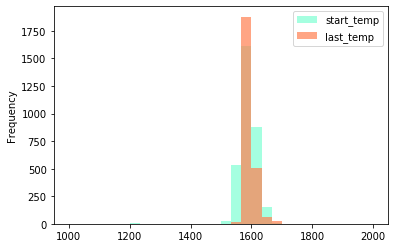

In [6]:
all_temp_data['start_temp'].plot.hist(bins=30, range=(1000, 2000), color= 'aquamarine', alpha=0.7)
all_temp_data['last_temp'].plot.hist(bins=30, range=(1000, 2000), color = 'coral', alpha=0.7)
plt.legend()
plt.show()

Посмотрим на выбросы в данных

**Первый замер**

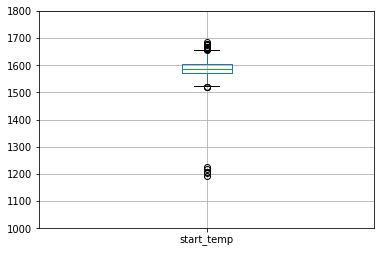

In [7]:
plt.ylim(1000, 1800)
all_temp_data.boxplot('start_temp')
plt.show()

Значения меньше 1520 и больше 1650 являются выбросами

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
С выбросами тут действительно важный момент. Ведь выброс выбросу рознь) Бывает, что выброс - то реальная бизнес-практика. И если удалить их, то мы получим модель, так скажем, работующую не во всех диапазонах входящих в неё факторов. Т.е. по метрикам модель будет хорошая. А вот по бизнесу - не совсем применимая.<br>А бывают выбросы - точно выбросы - ошибки учёта данных, например.<br>
    
В самой теории выбросов принято считать, что выбросы в интервале от q_3 + 1.5*irq до q_3 + з*irq - на усмотрение бизнеса. А вот всё, что больше q_3 + 3*irq - уже точно надо работать - на удаление!!!<br>
q_3 - верхняя квартиль<br>
irq - интерквартильный размах

В таких проектах, также лучше использовать такую философию анализа выбросов:<br>
Ящик с усами - даёт пищу для размышлений (не более того, не воспринимаем его как сигнал к действию).<br>
А потом смотрим то явление, что изучаем. Данные значения - могут быть в реальности или нет?<br>
Вот в данном случае с температурой плавления: по справочнику она у металла = окло 1400+-, т.е. 1200 - действиетльно кажется очень странным значением. 

**Последний замер**

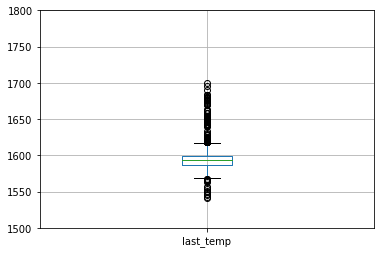

In [8]:
plt.ylim(1500, 1800)
all_temp_data.boxplot('last_temp')
plt.show()

Значения меньше 1570 и больше 1620 являются выбросами.

### Газ

Посмотрим на данные о поданном в сплав объеме газа. На гистограмме видно несколько выбросов на значении около 50

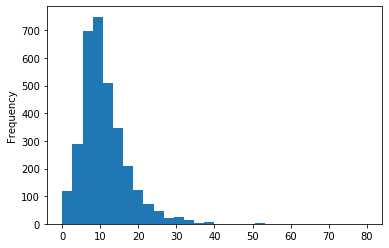

In [9]:
data_gas['Газ 1'].plot.hist(bins=30, range=(0, 80))
plt.show()

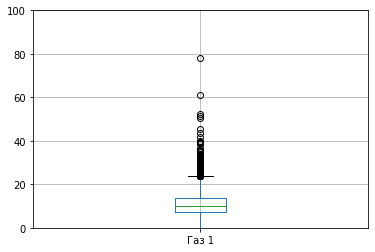

In [10]:
plt.ylim(0, 100)
data_gas.boxplot('Газ 1')
plt.show()

Значения больше 25 можно считать выбросами. Но глядя на гистограмму, я бы исключила только значения больше 35 или 40.

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>как и писал, выбросы всякие бывают)

### Данные об электродах

Рассмотрим данные об активной и реактивной мощности.

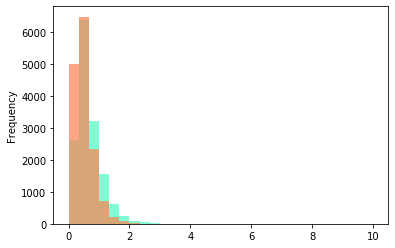

In [11]:
data_arc['Активная мощность'].plot.hist(bins=30, range=(0, 10), color= 'aquamarine')
data_arc['Реактивная мощность'].plot.hist(bins=30, range=(0, 10), color= 'coral', alpha=0.7)
plt.show()

**Активная мощность**

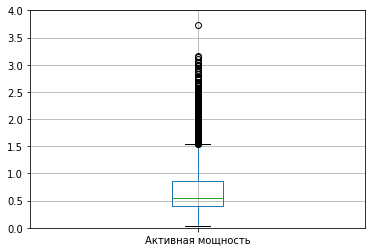

In [12]:
plt.ylim(0, 4)
data_arc.boxplot('Активная мощность')
plt.show()

**Реактивная мощность**

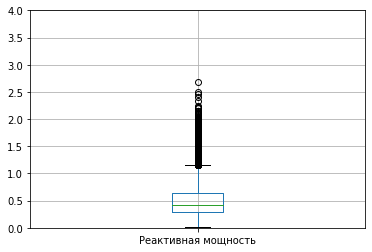

In [13]:
plt.ylim(0, 4)
data_arc.boxplot('Реактивная мощность')
plt.show()

По диаграммам размаха можно сказать, что для активной мощности выбросами являются значения выше 1.5, а для реактивной значения выше 1.2. Но если смотреть на гистограмму, видим относительно правный спад, к тому же разброс значений в обоих случаях всего до 3-4, так что я бы пренебрегла этими выбросами, они кажутся не ошибками в данных, а просто разнообразными случаями.

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>Ок, понятная работа по разделу)

## Подготовка данных <a id="step2"></a>  

Для удобства возмем в качестве features не каждую можность отдельного нагрева а сумму всех мощностей для партии и количество нагревов.
Остальные данные соединим с нашими температурами, чтобы получить общий датафрейм. Также подсчитаем количество времени которое прошло с первого до последнего замера.

В данных о примесях заменим пустые значения на нули, ведь они это и означают. Нет данных - нет примесей.

В общем датафрейме удалим ненужные столбцы, которые не будем использовать и переименуем русские названия на английские. Просто для единообразия.

In [14]:
data_arc_count = data_arc.groupby(by='key').count()
data_arc_sum = data_arc.groupby(by='key').sum()

In [15]:
data_wire = data_wire.fillna(0)
data_bulk = data_bulk.fillna(0)

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>ОК, принято)

In [16]:
all_data= all_temp_data.merge(data_arc_sum, on='key')
all_data = all_data.merge(data_arc_count['Начало нагрева дугой'], on='key')
all_data = all_data.merge(data_gas, on='key')
all_data = all_data.merge(data_bulk, on='key')
all_data = all_data.merge(data_wire, on='key')
all_data['start_meas_time'] = pd.to_datetime(all_data['start_meas_time'], format='%Y-%m-%dT%H:%M:%S')
all_data['last_meas_time'] = pd.to_datetime(all_data['last_meas_time'], format='%Y-%m-%dT%H:%M:%S')
all_data['time'] = (all_data['last_meas_time'] - all_data['start_meas_time']) // pd.Timedelta('1s')
all_data = all_data.drop(['start_meas_time', 'last_meas_time'], axis=1).rename(columns = {'Активная мощность': 'active_power_sum', 
                                                                                'Реактивная мощность' : 'reactive_power_sum', 
                                                                                'Начало нагрева дугой' : 'number_heatings',
                                                                                         'Газ 1': 'gas'})
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3022 entries, 0 to 3021
Data columns (total 32 columns):
key                   3022 non-null int64
start_temp            3022 non-null float64
last_temp             2329 non-null float64
active_power_sum      3022 non-null float64
reactive_power_sum    3022 non-null float64
number_heatings       3022 non-null int64
gas                   3022 non-null float64
Bulk 1                3022 non-null float64
Bulk 2                3022 non-null float64
Bulk 3                3022 non-null float64
Bulk 4                3022 non-null float64
Bulk 5                3022 non-null float64
Bulk 6                3022 non-null float64
Bulk 7                3022 non-null float64
Bulk 8                3022 non-null float64
Bulk 9                3022 non-null float64
Bulk 10               3022 non-null float64
Bulk 11               3022 non-null float64
Bulk 12               3022 non-null float64
Bulk 13               3022 non-null float64
Bulk 14          

Удалим те строки, у которых наш целевой признак (результат последнего замера температуры) оказался пустой.

In [17]:
all_data = all_data.drop(all_data.loc[all_data['last_temp'].isna(),:,].index)
all_data

,key,start_temp,last_temp,active_power_sum,reactive_power_sum,number_heatings,gas,Bulk 1,Bulk 2,Bulk 3,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,time
0,1,1571.0,1613.0,4.878147,3.183241,5,29.749986,0.0,0.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,861
1,2,1581.0,1602.0,3.052598,1.998112,4,12.555561,0.0,0.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1305
2,3,1596.0,1599.0,2.525882,1.599076,5,28.554793,0.0,0.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1300
3,4,1601.0,1625.0,3.209250,2.060298,4,18.841219,0.0,0.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,388
4,5,1576.0,1602.0,3.347173,2.252643,4,5.413692,0.0,0.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,1570.0,1591.0,3.210690,2.360777,4,7.125735,0.0,0.0,21.0,...,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1137
2325,2496,1554.0,1591.0,4.203064,2.810185,6,9.412616,0.0,0.0,0.0,...,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1618
2326,2497,1571.0,1589.0,2.212379,1.851269,3,6.271699,0.0,0.0,0.0,...,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,717
2327,2498,1591.0,1594.0,3.408725,2.355428,5,14.953657,0.0,0.0,90.0,...,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1302


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>ДА!!!, внимательная работа.

Разделим данные на целевой признак и features.

In [18]:
target = all_data['last_temp']
features = all_data.drop(['last_temp'], axis=1)

Посмотрим на корреляцию данных. Так как данных много возьмем только основные. Потому что все фичи не влезут на график.

In [19]:
data_corr = features.pivot_table(index = 'key', values = ['start_temp', 'active_power_sum', 
                                                          'reactive_power_sum', 'number_heatings', 'gas', 'time'])#, 
                                                         # 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 
                                                         # 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 
                                                         # 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'Wire 1', 
                                                         # 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 
                                                         # 'Wire 7', 'Wire 9', 'Wire 8'])
data_corr.corr()

,active_power_sum,gas,number_heatings,reactive_power_sum,start_temp,time
active_power_sum,1.000000,0.373832,0.760486,0.088484,-0.347718,0.537754
gas,0.373832,1.000000,0.404036,0.025247,0.037341,0.454465
number_heatings,0.760486,0.404036,1.000000,0.063753,-0.141478,0.587073
reactive_power_sum,0.088484,0.025247,0.063753,1.000000,-0.018022,0.049581
start_temp,-0.347718,0.037341,-0.141478,-0.018022,1.000000,0.173999
time,0.537754,0.454465,0.587073,0.049581,0.173999,1.000000


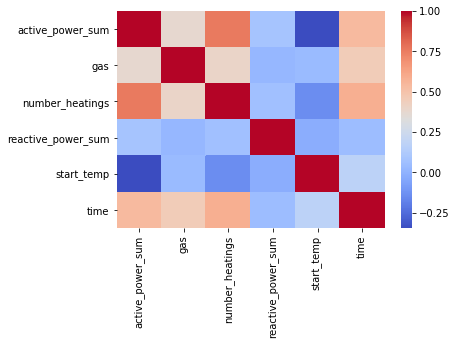

In [20]:
sns.heatmap(data_corr.corr(), cmap= 'coolwarm')
plt.show()

Далее, разделим наши данные на тестовую и обучающую выборки. И удалим key так как он точно не является полезным.

In [21]:
features = features.drop(['key'], axis=1)

In [22]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)

Масштабируем данные

In [23]:
numeric = ['start_temp', 'active_power_sum', 'reactive_power_sum', 'number_heatings', 'gas']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

In [24]:
features

,start_temp,active_power_sum,reactive_power_sum,number_heatings,gas,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,time
0,1571.0,4.878147,3.183241,5,29.749986,0.0,0.0,0.0,43.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,861
1,1581.0,3.052598,1.998112,4,12.555561,0.0,0.0,0.0,73.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1305
2,1596.0,2.525882,1.599076,5,28.554793,0.0,0.0,0.0,34.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1300
3,1601.0,3.209250,2.060298,4,18.841219,0.0,0.0,0.0,81.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,388
4,1576.0,3.347173,2.252643,4,5.413692,0.0,0.0,0.0,78.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,1570.0,3.210690,2.360777,4,7.125735,0.0,0.0,21.0,0.0,0.0,...,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1137
2325,1554.0,4.203064,2.810185,6,9.412616,0.0,0.0,0.0,63.0,0.0,...,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1618
2326,1571.0,2.212379,1.851269,3,6.271699,0.0,0.0,0.0,85.0,0.0,...,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,717
2327,1591.0,3.408725,2.355428,5,14.953657,0.0,0.0,90.0,0.0,0.0,...,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1302


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='red'><br>Фактор кей - лучше не использовать как фактор, это просто цифры. В нём нет бизнес-велью для целевой.

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>Тут особых показаний нет для масштабирования. Но, как говорится, кашу маслом не испортишь)

## Обучение моделей <a id="step3"></a>  

Перед нами стоит задача регрессии, поэтому обучим несколько регрессионных моделей и посмотрим какая из них покажет наилучший результат.

**Линейная регрессия**

In [25]:
LinearReg = LinearRegression()
LinearReg.fit(features_train, target_train)
predictions_LinearReg = pd.DataFrame(LinearReg.predict(features_valid), columns=['LinearReg_predict'])

**CatBoost**

In [26]:
cat = CatBoostRegressor(loss_function='MAE', iterations=1, learning_rate=1, depth=10)
cat.fit(features_train, target_train)
predictions_cat = pd.DataFrame(cat.predict(features_valid), columns=['cat_predict'])

0:	learn: 6.2101938	total: 172ms	remaining: 0us


**Random Forest Regressor**

In [27]:
RandomForest = RandomForestRegressor(max_depth=30, n_estimators = 60, random_state=12345)
RandomForest.fit(features_train, target_train)
predictions_RandomForest = pd.DataFrame(RandomForest.predict(features_valid), columns=['RandomForest_predict'])

**Decision Tree Regressor**

In [28]:
DecisionTree = DecisionTreeRegressor(max_depth=6)
DecisionTree.fit(features_train, target_train)
predictions_DecisionTree = pd.DataFrame(DecisionTree.predict(features_valid), columns=['DecisionTree_predict'])

**LightGBM**

In [29]:
lgb_train = lgb.Dataset(features_train, target_train)
lgb_eval = lgb.Dataset(features_valid, target_valid, reference=lgb_train)

params = {'metric': {'mae'}}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=150,
                valid_sets=lgb_eval,
                early_stopping_rounds=30)
lgb_predictions = pd.DataFrame(gbm.predict(features_valid, num_iteration=gbm.best_iteration))

[1]	valid_0's l1: 8.10557
Training until validation scores don't improve for 30 rounds
[2]	valid_0's l1: 7.83278
[3]	valid_0's l1: 7.58712
[4]	valid_0's l1: 7.38111
[5]	valid_0's l1: 7.23444
[6]	valid_0's l1: 7.08142
[7]	valid_0's l1: 6.93207
[8]	valid_0's l1: 6.82213
[9]	valid_0's l1: 6.72075
[10]	valid_0's l1: 6.63421
[11]	valid_0's l1: 6.51175
[12]	valid_0's l1: 6.43614
[13]	valid_0's l1: 6.386
[14]	valid_0's l1: 6.31068
[15]	valid_0's l1: 6.23537
[16]	valid_0's l1: 6.17894
[17]	valid_0's l1: 6.15161
[18]	valid_0's l1: 6.1003
[19]	valid_0's l1: 6.06576
[20]	valid_0's l1: 6.04165
[21]	valid_0's l1: 6.00396
[22]	valid_0's l1: 5.98389
[23]	valid_0's l1: 5.95927
[24]	valid_0's l1: 5.93138
[25]	valid_0's l1: 5.91215
[26]	valid_0's l1: 5.89601
[27]	valid_0's l1: 5.87315
[28]	valid_0's l1: 5.86514
[29]	valid_0's l1: 5.8507
[30]	valid_0's l1: 5.85406
[31]	valid_0's l1: 5.84146
[32]	valid_0's l1: 5.82949
[33]	valid_0's l1: 5.82986
[34]	valid_0's l1: 5.83029
[35]	valid_0's l1: 5.82046
[36]	va

## Оценка моделей <a id="step4"></a>  

In [30]:
print('MAE Linear Regression:', mean_absolute_error(target_valid, predictions_LinearReg))

MAE Linear Regression: 6.342183908965219


In [31]:
print('MAE CatBoostRegressor:', mean_absolute_error(target_valid, predictions_cat))

MAE CatBoostRegressor: 8.066895367884797


In [32]:
print('MAE Random Forest Regressor:', mean_absolute_error(target_valid, predictions_RandomForest))

MAE Random Forest Regressor: 5.950543167524298


In [33]:
print('MAE Decision Tree Regressor:', mean_absolute_error(target_valid, predictions_DecisionTree))

MAE Decision Tree Regressor: 7.12844910050853


In [34]:
print('MAE LightGBM:', mean_absolute_error(target_valid, lgb_predictions))

MAE LightGBM: 5.746394525153782


Лучший результат показала модель **LightGBM**. Посмотрим на важность признаков для этой модели

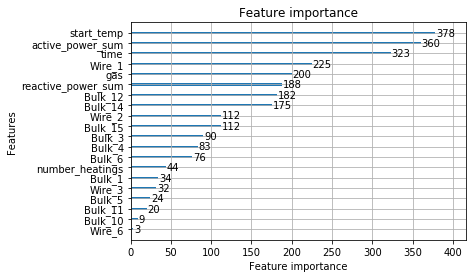

In [35]:
lgb.plot_importance(gbm)
plt.show()

Видим, что 3 самых важных фактора это начачльная температура, суммарная активная мощность и время, которое прошло с 1 нагрева до последнего.

Сравним показатели нашей моделей с Dummy моделью

In [36]:
dummy_reg = DummyRegressor(strategy="mean")

dummy_reg.fit(features_train, target_train)
predictions_Dummy = pd.DataFrame(dummy_reg.predict(features_valid), columns=['dummy_predict'])
print('MAE Dummy:', mean_absolute_error(target_valid, predictions_Dummy))

MAE Dummy: 8.396983843492315


LightGBM очвидно лучше чем среднее значение.

Для успокоения души посмотрим как выглядят наши предсказания на гистограмме и сравним их с настоящими замерами.

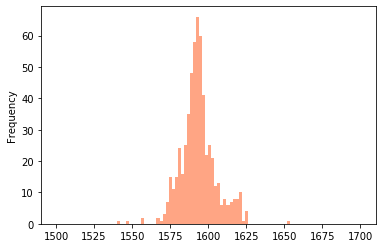

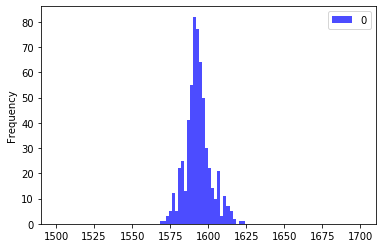

In [37]:
target_valid.plot.hist(bins=100, range=(1500, 1700), color = 'coral', alpha=0.7)
lgb_predictions.plot.hist(bins=100, range=(1500, 1700), color = 'blue', alpha=0.7)

Вывод: Выбираем модель LightGBM, которая показала наилучший результат метрики МАЕ = 5.74.

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
Ксения, скажу, что уверенная работа, на мой взгляд)<br>
Обработка данных, модельная работа, конечные результаты - многое удалось как надо<br> Очень здорово, что сразу ищешь новые фичи, думаешь над ними, анализируешь. Это тот самый подход, который нужен, чтобы искать ту саму модель для заказчика)<br> Осталось лишь несколько вопросов с моей стороны))<br>
<font color='red'>    
1) При моделировании существует проблематика мультиколлинеарности.(когда количественные факторы модели имеют сильную корреляцию друг с другом - больше 0.8).Есть ли она у нас?  Если есть - надо  решать по понятиям:) (удалить лишнее)<br><br>
    
2) Попробуй с помощью команды feature_importances_ выводить график важности факторов. Отличная вещь будет: высока яметрика + график рейтинаг факторов по силе влияния на целевой признак). Важнейшая часть любого модельного финала.
Если видно, что часть факторов - слабозначимые для модели. Т.е. не значительно влияют на целевую переменную, то их смело можно убирать из модели. Ну и для бизнеса доносить: так мол и так - на эти факторы надо обращать внимание, а эти не влияют.<br>
    
3) ну и фактор кей - лучше убрать)<br>
    
<font color='green'>
<font color='green'>
Однозначно видно, что ты технически сделал хорошую работу.<br>
Просто эти пунктs - важный момент в алгоритме моделирования. И хотелось, чтобы они у тебя остались в финале.<br>

Спасибо)<br>
БУДУ ЖДАТЬ КОММЕНТАРИЕВ.

<div class="alert alert-info">
Привет!
    
Фактор key убрала и MAE на лучше модели немного перевалило за 6. Так что добавила еще одну фичу (время прошедшее с первого замера до последнего), чтобы метрика была больше шести. В итоге получилось лучше.

На мультиколлениальность посмотрела, но все фичи не влезают в график. излазила всю документацию, не нашла как сделать график более вместительным. Оставила там закомментированными остальные фичи, если хочешь, посмотри, что происходит если их все указать.

Вывела важность факторов для лучшей из моделей
</div>

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА 2</u></b>
</font>
<font color='green'><br>
Ксения, с доработками - всё в точку у тебя по важности.<br>
А по мультиколлинеарности можжно вывести корреляции в таблице, не на картинке. Картинка - действительно только для случаев, когда факторов не более 15, мне кажется. Но изучать эту проблематику (мультиколлинеарность) обязательно надо. <br>
Тут два аспекта можно рассматривать:<br>
1) математический: когда два фактора имеют сильную корреляцию, то при матричных вычислениях внутри некоторых методов наступаю сложности. И самим методам внутри прихрдится их решать. Это может давать некторые сложности в расчётах. Плюс - скорость самих расчётов снижается.<br>
2) бизнесово-логичесвкая: если два фактора очень сильно связаны друг с другом, то значит они имеют примерно одинаковое влияние на целевую переменную. А значит какой смысл оба их держать в модели. Напрмиер, каким-то образом попадутся факторы скорости, измеренные в км/ч и м/с - тут всем ясно (и бизнесу в том числе), что один фактор - излишний. При этом, как писал выше, есть понятие ложной корреляции. Если факторы имеют высокую корреляцию, НО логически НИКАК не связы друг с другом, то надо поисследолвать ещё, прежде чем удалять)<br>

 
А в целом - добротная работа. <br>
Также, всегда стараюсь на этом проекте сказать всем вот ещё что: цель заказчика - экономия энергоресурсов.<br>
И в этом проекте искали как раз способ точно предсказывать температуру. И круто использовали для этого весь арсенал<br>
А если рассудать с позиции такой: а что нужно сделать, чтобы снизить энергопотребление?<br>
Судя по модели, самым важным фактором является первая температура. Это значит, что управляя ею, мы сможем управлять энергозатратами. Вывод понятен. Теперь надо разработать мероприятия для этого решения. И тут вопрос возникает скм собой: а это так точно? мы можем управлять первой температурой? В общем, наша модель - только начало работы над энергоэффективностью.<br>
    
Так же есть ещё одна идея, которую хотел предложить тебе на обсуждение.<br>
Возможно, покажется интересным<br><br> 

Дело касается принципиально иного подхода к поиску решения для снижения энергопотребления на производстве<br>
Смотри, Создание данной модели (таково было задание) двигалось по пути "угадывания" температуры<br>
Но мы же знаем жизнь)) лёгкие колебания температур (как и нашего настроения, нашего веса.....)<br>
есть всегда. Более того - будут вегда! И нам что, стараться угадывать их?<br>
Не угонимся, "пупок" развяжется))))) <br>
Предложу для подобных проектов подумать вот в какую сторону<br>
    
Итак, разброс в измерениях - есть, был и будет!! (т.к. этому благоприятствует разнообразие факторов самого проиозводства)<br>
    Тогда задачу можно поставить так: <u>надо уменьшить разброс в измерениях</u>. В данном случае в температуре.<br>
Один из подходов такой: Наверняка есть границы, в пределах которых колебания температур - дело нормальное.<br>
А что, если фикировать случаи, когда температура выходит за эти границы?<br>
Скажем, как "1". И тогда для таких моментов времени собирать инфо по производству: <br>
а что был за материал (химия материала), что был за газ (химический состав газа), какая бригада работала, <br>
что там было с электродами, ограничения только в фантазиях ну и в знаниях самого производства..... <br>
И вот тут можем реально находить причины (через корреляции, проверки гипотез, разные модельки...), фиксировать эти причины. <br>
Ну и разрабатывать энергосберегательные мероприятия.<br><br>
 
<font color='green'>

Спасибо за этот труд и за совместную работу на других проектах)<br>
Искренне желаю покорить ещё не один аналитический Эверест)

# Отчет

*(Я не поняла, нужна чистая тетрадь или с комментраиями ревьюера, оставила с комментариями)*

**Анализ данных**

Были проанализированы предоставленные признаки. 
Для многих партий обнаружены пропуски в целевом признаке (результат последнего измерения температуры).
Изучен разброс данных по гистограммам и диаграмме размаха для показателей:
* Температура (первый и последний замер)
* Объем газа
* Активная мощность
* Реактивная мощность

Во всех случаях распределение выглядит как нормальное. Выбросы есть, но больше похожи на длинные хвосты нормального распределения а не на ошибки в данных.

**Подготовка данных**
* Выбросили серединные замеры температуры (со второй по предпоследнюю) так как использовать их мы не можем по услови задачи;
* Активные и реактивные мощности всех этапов нагрева сложили в суммарную активную и суммарную реактивную можность;
* Для каждой партии подсчитали количество нагревов;
* Для каждой партии подсчитали временной интервал между первым и последним измерением температуры;
* В данных о примесях (как сыпучих так и провологки) заменили Nan на нули, так как Nan означает отсутствие добавления примесей;
* Изучили возможные корреляции в основных признаках, чтобы удалить признаки со слишком высокой корреляцией (таких не обнаружилось);
* Масштабировали признаки.

Финальный датафрейм для обучения (features) по итогу содержит:
* start_temp - результат первого замера температуры;
* active_power_sum - суммарная активная мощность для партии;
* reactive_power_sum - суммарная реактивная мощность для партии;
* number_heatings - количество нагревов партии;
* gas - объем газа;
* time - разница во времени между первым и последним замером;
* Bulk (1-15) - объем тех или иных сыпучих примесей в партии;
* Wire (1-9) - объем проволочных примесей в партии.

Целевой признак (target) содержит результат последнего замера температуры партии

**Выбор модели и результаты обучения**

Для задачи регрессии обучили и сравнили результаты 5 моделей регрессии.

|Model         | MAE           |
| ------------- |:-------------:|
| Linear Regression      | 6.342183908965219 |
| CatBoost Regressor      | 8.066895367884797 |
| Random Forest Regressor | 5.950543167524298 |
| Decision Tree Regressor | 7.12844910050853 |
| LightGBM                | 5.746394525153782 |

Наилучший результат показала модель **LightGBM - 5.74**

**Выводы**
По наилучшей модели посмотрели самые важные признаки. Топ 5 фичей:
1. start_temp
2. active_power_sum
3. time
4. Wire 1
5. reactive_power_sum

Все пункты плана были выполнены, дополнительно из существующих признаков были сгенерированы новые (количество нагревов, разница во времени между первым и последним замером). 

Основные трудности были связаны с пониманием процесса и, как следствие, с обработкой данных. Сложность с несколькими наблюдениями в рамках одной партии была решена обобщением признаков разных замеров (суммирование мощностей, подсчет количества итераций нагрева). Так победили)